# PyOpenCAP and Q-Chem
In this tutorial we, post process results from Q-Chem calculations to analyze eigenvalue trajectories for CAP/EOM-CC and CAP-ADC calculations on the ${}^2\Pi_g$ shape resonance of $N_2^-$. We use the pyopencap.analysis submodule to extract the matrices and analyze the trajectories.

In [1]:
from pyopencap.analysis import CAPHamiltonian
import matplotlib.pyplot as plt
import numpy as np

# EOM-CC

## Option 1: Analysis of .fchk files

For EOM-CC calculations, one particle densities from a Projected CAP-EOM-CC can be exported to .fchk using GUI=2. The snippet below can be used to post-process the outputs generated by Q-Chem in order to obtain the zeroth order Hamiltonian and the CAP matrix.

In [2]:
import pyopencap
sys_dict = {"molecule":  "qchem_fchk",
            "basis_file": "ref_outputs/qc_inp.fchk"
}

cap_dict = {
            "cap_type": "box",
            "cap_x":"2.76",
            "cap_y":"2.76",
            "cap_z":"4.88"
}

es_dict = { "package": "qchem",
            "method" : "eom",
           "qchem_output":"ref_outputs/qc_inp.out",
           "qchem_fchk":"ref_outputs/qc_inp.fchk",
}

s = pyopencap.System(sys_dict)
pc = pyopencap.CAP(s,cap_dict,5)
pc.read_data(es_dict)
pc.compute_projected_cap()
W = pc.get_projected_cap()
H0 = pc.get_H()

Successfully read in zeroth order Hamiltonian from file:ref_outputs/qc_inp.out
Reading densities from file:ref_outputs/qc_inp.fchk
Done.
Verified overlap matrix.
Integration time:3.340326


Some other helpful functions:


In [3]:
# recompute cap in AO basis with different cap parameters
cap_dict = {"cap_type": "voronoi","r_cut":"3.00"}
pc.compute_ao_cap(cap_dict)
pc.compute_projected_cap()
# retrieve CAP matrix
ao_cap = pc.get_ao_cap()

Redefining CAP parameters...

Integration time:3.199561


TypeError: get_ao_cap(): incompatible function arguments. The following argument types are supported:
    1. (self: pyopencap.pyopencap_cpp.CAP, ordering: str, basis_file: str = '') -> numpy.ndarray[float64[m, n]]

Invoked with: <pyopencap.CAP.CAP object at 0x108169f10>

There are two equivalent ways from here of generating the CAPHamiltonian object for analysis:

In [ ]:
CAPH = CAPHamiltonian(H0=H0,W=W)
CAPH = CAPHamiltonian(pc=pc)

## Option 2: Post-processing Projected CAP-EOM-CC Q-Chem outputs
Projected CAP-EOM-CC is implemented in Q-Chem (available as of Q-Chem 5.4), and can be requested using the PROJ_CAP=3 keyword in complex_ccman. PyOpenCAP is capable of performing analysis directly from outputs generated by this calculation. 

In [7]:
from pyopencap.analysis import CAPHamiltonian
import matplotlib.pyplot as plt
import numpy as np
# Q-Chem output, can specify irrep
CAPH = CAPHamiltonian(output="ref_outputs/eomcc.out",irrep="B2g")
# OpenCAP output
CAPH = CAPHamiltonian(output="ref_outputs/n2_opencap.out")

The eigenvalue trajectories are generated using run_trajectory, which requires a list of $\eta$ values. One can include or exclude states from the subspace projection using the include_states and exclude_states keyword arguments. For instance:

In [8]:
eta_list = np.linspace(0,5000,101)
eta_list = np.around(eta_list * 1E-5,decimals=5)
CAPH.run_trajectory(eta_list,include_states=[0,1,2,3])
CAPH.run_trajectory(eta_list,exclude_states=[4])
CAPH.run_trajectory(eta_list)

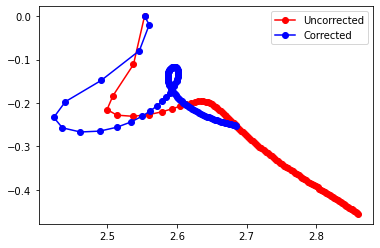

In [9]:
# ccsd energy of neutral
ref_energy = -109.36195558
# tracking options are energy and eigenvector overlap
traj = CAPH.track_state(1,tracking="energy")
uc_energies = traj.energies_ev(ref_energy=ref_energy)
corr_energies = traj.energies_ev(ref_energy=ref_energy,corrected=True)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.legend()
plt.show()

Uncorrected:
(2.638107668561583-0.19603024085219747j)
(-109.26500691135396-0.00720397847724865j)
0.0075
Corrected:
(2.5968614903724485-0.11703372791272688j)
0.0165
(-109.26695259557975-0.00680682721957396j)


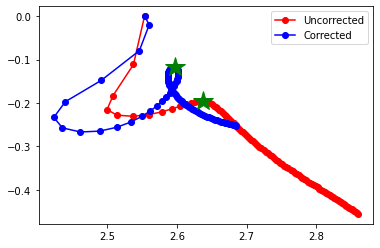

In [10]:
# Find optimal value of eta
uc_energy, eta_opt = traj.find_eta_opt(start_idx=10,ref_energy=ref_energy,units="eV")
# start_idx and end_idx for search use python slice notation (i.e. [start_idx:end_idx]). 
corr_energy, corr_eta_opt = traj.find_eta_opt(corrected=True,start_idx=10,end_idx=-1,ref_energy=ref_energy,units="eV")
uc_energy_au = traj.get_energy(eta_opt,units="au")
corr_energy_au = traj.get_energy(eta_opt,units="au",corrected=True)
print("Uncorrected:")
print(uc_energy)
print(uc_energy_au)
print(eta_opt)
print("Corrected:")
print(corr_energy)
print(corr_eta_opt)
print(corr_energy_au)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.plot(np.real(uc_energy),np.imag(uc_energy),'g*',markersize=20)
plt.plot(np.real(corr_energy),np.imag(corr_energy),'g*',markersize=20)
plt.legend()
plt.show()

## ADC

Starting from Q-Chem 5.4, CAP-ADC calculations can be performed using the ADC_CAP keyword. PyOpenCAP is capable of performing analysis directly from outputs generated by this calculation Here, we a analyze CAP-EA-ADC(2) calculation.

In [11]:
# Q-Chem output, can specify onset
CAPH = CAPHamiltonian(output="ref_outputs/adc.out", onset="3000")

In [12]:
eta_list = np.linspace(0,3000,101)
eta_list = np.around(eta_list * 1E-5,decimals=5)
CAPH.run_trajectory(eta_list)

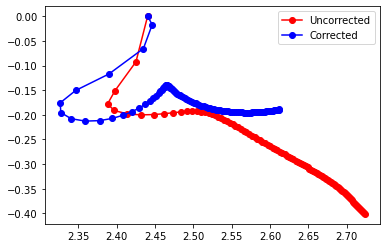

In [13]:
traj = CAPH.track_state(1,tracking="overlap")
uc_energies = traj.energies_ev(0.0)
corr_energies = traj.energies_ev(0.0,corrected=True)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.legend()
plt.show()

Uncorrected:
(2.5101927746675394-0.19385933001332462j)
(2.5101927746675394-0.19385933001332462j)
0.0042
Corrected:
(2.4653433707989607-0.1399004750155618j)
0.0081


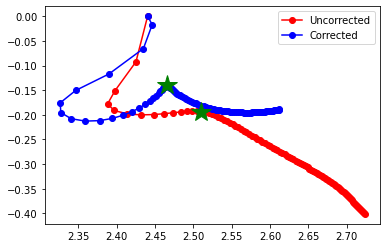

In [14]:
# Find optimal value of eta
uc_energy, eta_opt = traj.find_eta_opt(start_idx=10,units="eV")
corr_energy, corr_eta_opt = traj.find_eta_opt(corrected=True,start_idx=10,units="eV")
print("Uncorrected:")
print(uc_energy)
# one can also obtain energies by value of eta
print(traj.get_energy(eta_opt,units="eV"))
print(eta_opt)
print("Corrected:")
print(corr_energy)
print(corr_eta_opt)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.plot(np.real(uc_energy),np.imag(uc_energy),'g*',markersize=20)
plt.plot(np.real(corr_energy),np.imag(corr_energy),'g*',markersize=20)
plt.legend()
plt.show()

## Plotting logarithmic velocities:

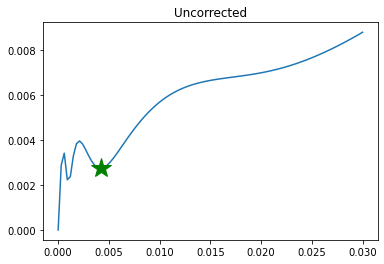

In [15]:
# uncorrected
derivs = traj.get_logarithmic_velocities()
plt.plot(traj.etas,derivs)
plt.plot(eta_opt,derivs[traj.etas.index(eta_opt)],'g*',markersize=20)
plt.title("Uncorrected")
plt.show()

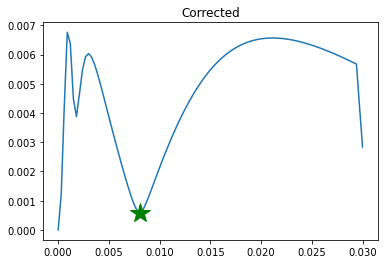

In [16]:
# corrected
derivs = traj.get_logarithmic_velocities(corrected=True)
plt.plot(traj.etas,derivs)
plt.plot(corr_eta_opt,derivs[traj.etas.index(corr_eta_opt)],'g*',markersize=20)
plt.title("Corrected")
plt.show()